In [1]:
import sys

import itertools
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from batch_gen import SixNumbersBatch
sys.path.append('../..')
import utils
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST
from dataset.models.tf import Inception_v4, DenseNet169, ResNet101, MobileNet, SqueezeNet

In [2]:
dset = MNIST(batch_class=SixNumbersBatch)

Downloaded t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Downloaded train-labels-idx1-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Downloaded t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Downloaded train-images-idx3-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz


In [3]:
ppl = (Pipeline()
       .gluing_of_images()
       .resize(shape=(128, 320))
       .normalize_images()
       .one_hot())

In [4]:
models = [Inception_v4, DenseNet169, ResNet101, MobileNet, SqueezeNet]
models_names = ['Inception_v4', 'DenseNet169', 'ResNet101', 'MobileNet', 'SqueezeNet']
models_dict = dict(zip(models_names, models))

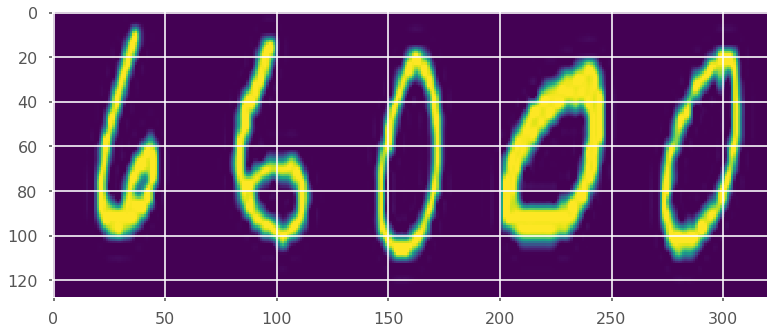

In [5]:
b = (ppl<<dset.train).next_batch(15)
plt.imshow(b.images[0].reshape(128,320))

In [6]:
def reshape_loss(target, predictions):
    target = tf.reshape(target, [-1, 5, 10])
    predictions = tf.reshape(predictions, [-1, 5, 10])
    return tf.losses.softmax_cross_entropy(target, predictions)

In [7]:
inputs_config = {
    'images': {'shape':(128, 320, 1)},
    'labels':{'shape':(50), 'name':'targets'}
}

config = {
    'inputs':inputs_config,
    'optimizer': 'Adam',
    'loss': reshape_loss,
    'input_block/inputs': 'images',
    'head/units': 50,
    'output': dict(ops=['labels', 'proba', 'accuracy'])}

feed_dict = {
    'images': B('images'),
    'labels': B('labels')
}

In [8]:
def get_ppl(model, name):
    train_ppl = ((ppl<<dset.train)
                        .init_variable('model', model)
                        .init_variable('loss', init_on_each_run=list)
                        .init_model('dynamic',
                                    V('model'),
                                    name,
                                    config=config)
                       .train_model(name,
                                    fetches='loss',
                                    feed_dict=feed_dict,
                                    save_to=V('loss'), mode='a'))
    test_ppl = ((ppl<<dset.test)
                        .init_variable('proba', init_on_each_run=list)
                        .init_variable('target', init_on_each_run=list)
                        .import_model(name, train_ppl)
                        .predict_model(name,
                                      fetches=['output_proba',
                                               'targets'],
                                      feed_dict=feed_dict,
                                      save_to=[V('proba'), V('target')], mode='a'))
    return train_ppl, test_ppl

In [9]:
def calc_acc(targets, proba):
    proba = proba.reshape(-1, 5, 10)
    targets = targets.reshape(-1, 5, 10)
    proba = np.argmax(proba, axis=-1)
    targets = np.argmax(targets, axis=-1)
    return len(np.where(proba.reshape(-1) == targets.reshape(-1))[0])/len(targets.reshape(-1))

MobileNet


../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)


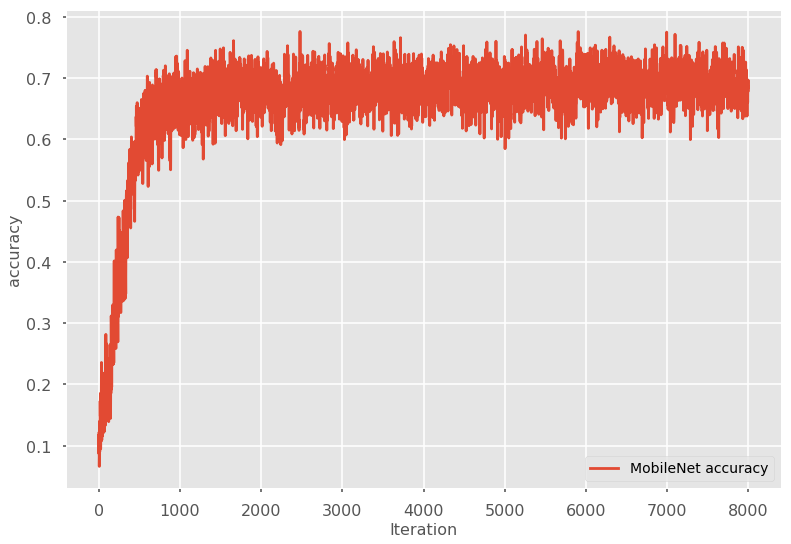

Inception_v4


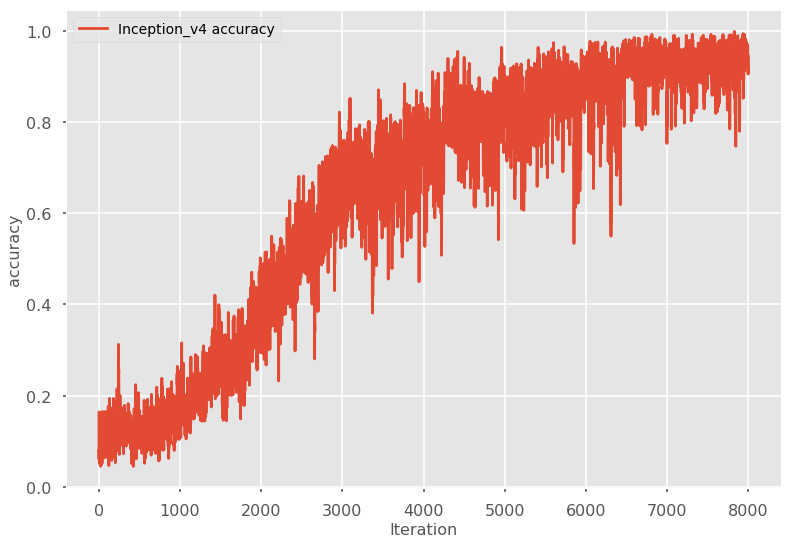

DenseNet169


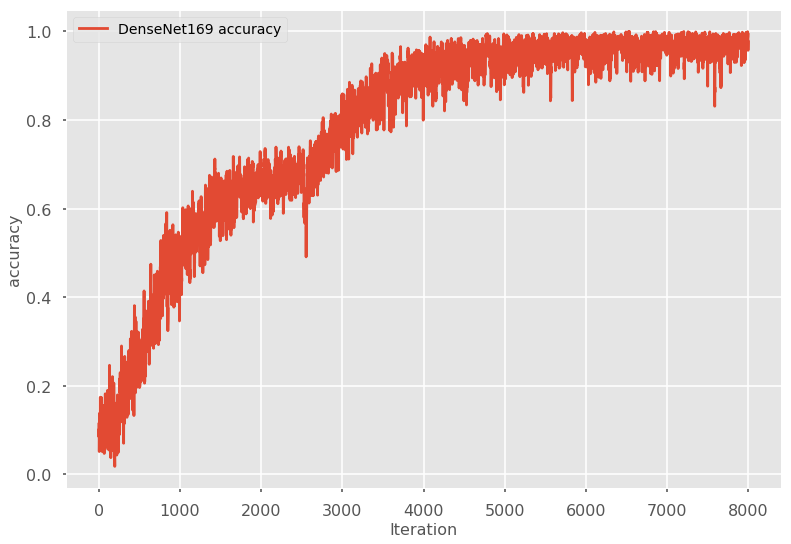

ResNet101


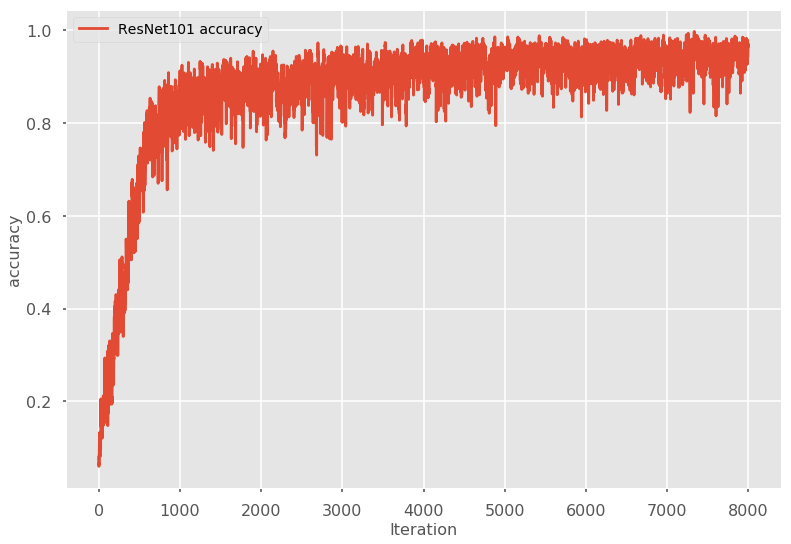

SqueezeNet


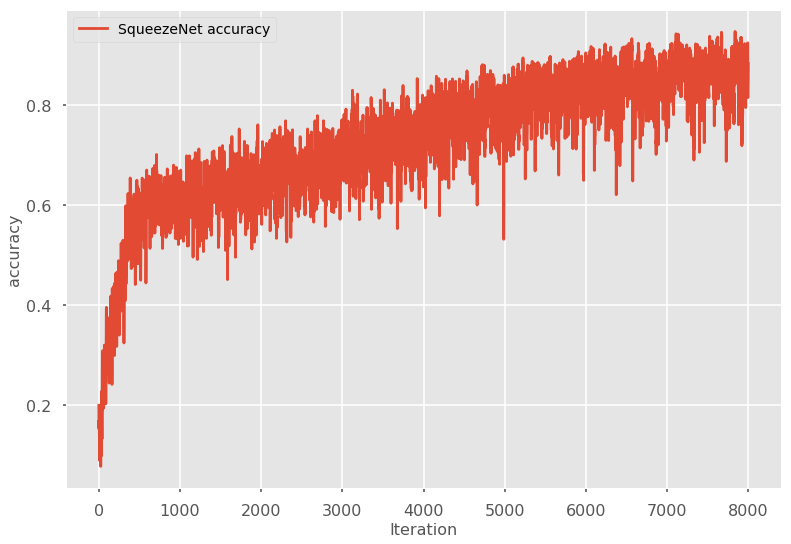

In [12]:
global_acc = []

for name, model in models_dict.items():
    print(name)
    train_ppl, test_ppl = get_ppl(model, name)
    acc=[]
    for i in tqn(range(8000)):
        train_ppl.next_batch(10, n_epochs=None, suffle=True)
        test_ppl.next_batch(10, n_epochs=None, suffle=True)
        proba = test_ppl.get_variable('proba')[-1]
        target = test_ppl.get_variable('target')[-1]
        acc.append(calc_acc(target, proba))

    utils.draw(acc, name, type_data='accuracy')
    plt.show()
    global_acc.append(acc)
    train_ppl.save_model(name, path=name)

In [15]:
model_tr = train_ppl.load('./Inception_v4')

test_ppl = ((ppl<<dset.train)
            .init_variable('proba', init_on_each_run=list)
            .init_variable('targets', init_on_each_run=list)
            .import_model('Inception_v4', list(model_tr.models.values())[0])
            .predict_model('Inception_v4',
                          fetches=['output_proba','targets'],
                          feed_dict=feed_dict,
                          save_to=[V('proba'), V('targets')], mode='a'))

batch = test_ppl.next_batch(100)

image = np.array(batch.images).reshape(-1, 128, 320)
true_numbers = np.array(test_ppl.get_variable('targets'))
predict = np.array(test_ppl.get_variable('proba'))
print('Accuracy: ', calc_acc(true_numbers, predict))
predict = predict.reshape(-1, 5, 10)
targets = true_numbers.reshape(-1, 5, 10)
predict = np.argmax(predict, axis=-1)
targets = np.argmax(targets, axis=-1)

indx_false = np.unique(np.where(predict != targets)[0])
indx_true = np.where(predict == targets)[0]

In [75]:
def draw(ind):
    for i in range(3):
        plt.imshow(image[ind[i]])
        plt.grid()
        plt.title('Graph №{} \nNetwork prediction: {} {} {} {} {}'.format(i, *predict[ind[i]]) \
                             + '\nreal answer: {} {} {} {} {}'.format(*targets[ind[i]]))
        plt.show()

# Примеры без ошибок

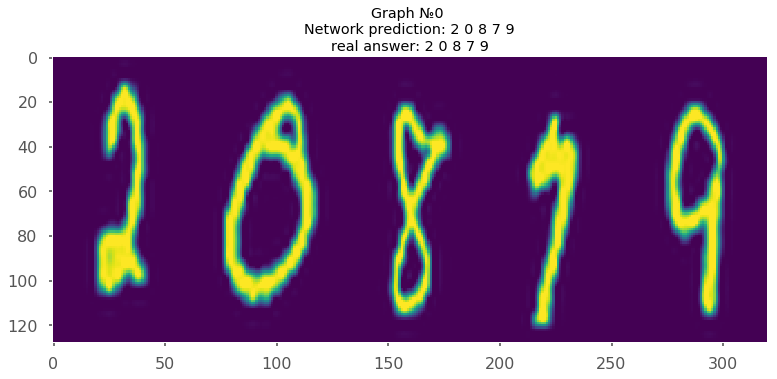

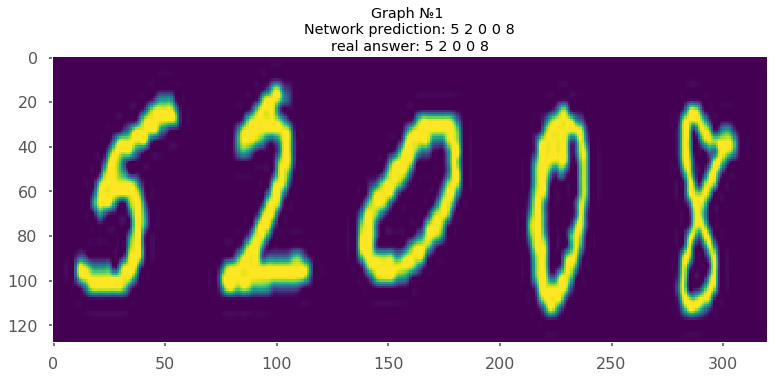

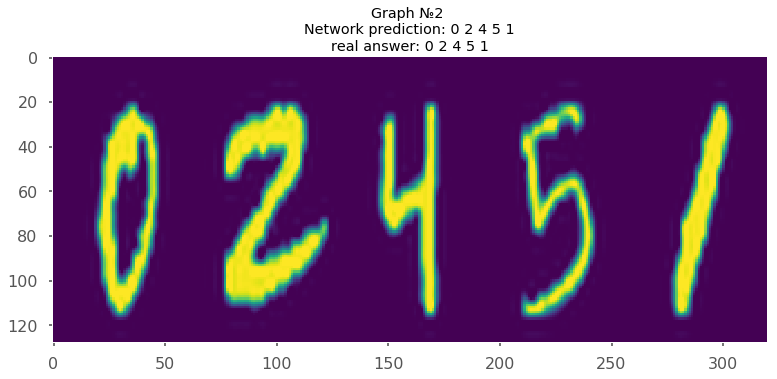

In [83]:
ind = np.random.choice(indx_true, 3)
draw(ind)

# Примеры с ошибками

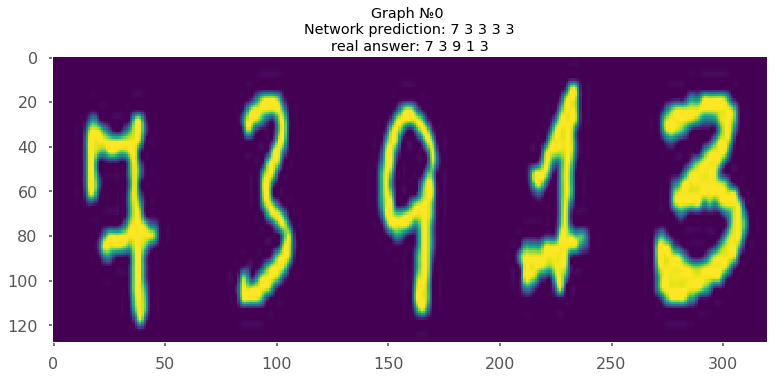

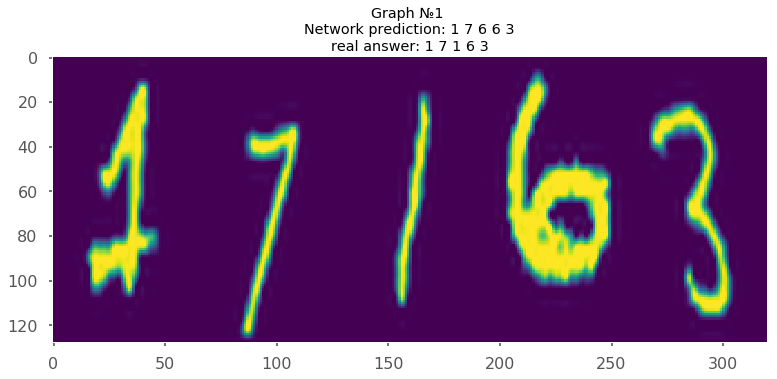

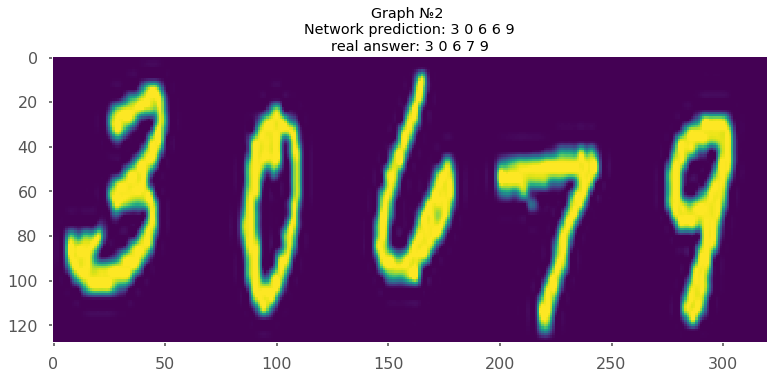

In [82]:
ind = np.random.choice(indx_false, 3)
draw(ind)